In this notebook, we will try using autoencoders to solve the anomaly detection problem. For data exploring and a solution using linear regression, please take a look on the notebook data_exploring_linear_model.

In [253]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [254]:
df = pd.read_csv('data/T1.csv')

In [255]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [256]:
# Rename columns
df = df.rename(columns = {'LV ActivePower (kW)'	: 'ActivePower'})
df = df.rename(columns = {'Theoretical_Power_Curve (KWh)'	: 'TheoreticalPower'})
df = df.rename(columns = {'Wind Direction (°)'	: 'WindDirection'})
df = df.rename(columns = {'Wind Speed (m/s)'	: 'WindSpeed'})

In [257]:
# Convert Date/Time feature to format day-month-year hour:minute
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format = '%d %m %Y %H:%M')
df['Date'] = df['Date/Time'].dt.date
df['Time'] = df['Date/Time'].dt.time

In [258]:
# Split date data
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [259]:
# Add the season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    elif month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    else: 
        return 2

In [260]:
df['Season'] = df['Month'].apply(get_season)

In [261]:
# Sort the unique time values and create a mapping of sorted times to numerical labels
sorted_times = sorted(df['Time'].unique())
time_to_label = {time: label for label, time in enumerate(sorted_times)}

# Map the 'Time' column to its numerical label based on the sorted order
df['EncodedTime'] = df['Time'].map(time_to_label)

In [262]:
df.drop(columns=['Date/Time', 'Date', 'Time'], inplace=True)

In [263]:
df.head()

,ActivePower,WindSpeed,TheoreticalPower,WindDirection,Day,Month,Year,Season,EncodedTime
0,380.047791,5.311336,416.328908,259.994904,1,1,2018,3,0
1,453.769196,5.672167,519.917511,268.641113,1,1,2018,3,1
2,306.376587,5.216037,390.900016,272.564789,1,1,2018,3,2
3,419.645905,5.659674,516.127569,271.258087,1,1,2018,3,3
4,380.650696,5.577941,491.702972,265.674286,1,1,2018,3,4


In [264]:
X = df.values
y = df.values

In [265]:
X

array([[3.80047791e+02, 5.31133604e+00, 4.16328908e+02, ...,
        2.01800000e+03, 3.00000000e+00, 0.00000000e+00],
       [4.53769196e+02, 5.67216682e+00, 5.19917511e+02, ...,
        2.01800000e+03, 3.00000000e+00, 1.00000000e+00],
       [3.06376587e+02, 5.21603680e+00, 3.90900016e+02, ...,
        2.01800000e+03, 3.00000000e+00, 2.00000000e+00],
       ...,
       [2.20110693e+03, 8.43535805e+00, 1.78828476e+03, ...,
        2.01800000e+03, 3.00000000e+00, 1.41000000e+02],
       [2.51569409e+03, 9.42136574e+00, 2.41838250e+03, ...,
        2.01800000e+03, 3.00000000e+00, 1.42000000e+02],
       [2.82046606e+03, 9.97933197e+00, 2.77918410e+03, ...,
        2.01800000e+03, 3.00000000e+00, 1.43000000e+02]])

In [266]:
y

array([[3.80047791e+02, 5.31133604e+00, 4.16328908e+02, ...,
        2.01800000e+03, 3.00000000e+00, 0.00000000e+00],
       [4.53769196e+02, 5.67216682e+00, 5.19917511e+02, ...,
        2.01800000e+03, 3.00000000e+00, 1.00000000e+00],
       [3.06376587e+02, 5.21603680e+00, 3.90900016e+02, ...,
        2.01800000e+03, 3.00000000e+00, 2.00000000e+00],
       ...,
       [2.20110693e+03, 8.43535805e+00, 1.78828476e+03, ...,
        2.01800000e+03, 3.00000000e+00, 1.41000000e+02],
       [2.51569409e+03, 9.42136574e+00, 2.41838250e+03, ...,
        2.01800000e+03, 3.00000000e+00, 1.42000000e+02],
       [2.82046606e+03, 9.97933197e+00, 2.77918410e+03, ...,
        2.01800000e+03, 3.00000000e+00, 1.43000000e+02]])

In [267]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [268]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40424, 9)
(40424, 9)
(10106, 9)
(10106, 9)


In [269]:
# Convert to pytorch
X = torch.tensor(X, dtype = torch.float)
y = torch.tensor(y, dtype = torch.float)
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

We have done a data preprocessing for the model. Let's now define the model.

In [270]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [271]:
import torch.optim as optim

input_size = X_train.shape[1]
hidden_size = 4
model = Autoencoder(input_size, hidden_size)

# Define loss function and optimizer
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [272]:
# Traing the model
n_epochs = 3
for i in range(n_epochs):
    MSELoss = 0
    for x, y_true in zip(X_train, y_train):
        output = model.forward(x)
        loss = criterion(output, y_true)
        MSELoss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 1 == 0:
        print(f"Step {i}")
        print(f"MSELoss: {MSELoss/X_train.shape[0]}")

Step 0
MSELoss: 13985.63846637182
Step 1
MSELoss: 12794.500100137455
Step 2
MSELoss: 12788.445145512958


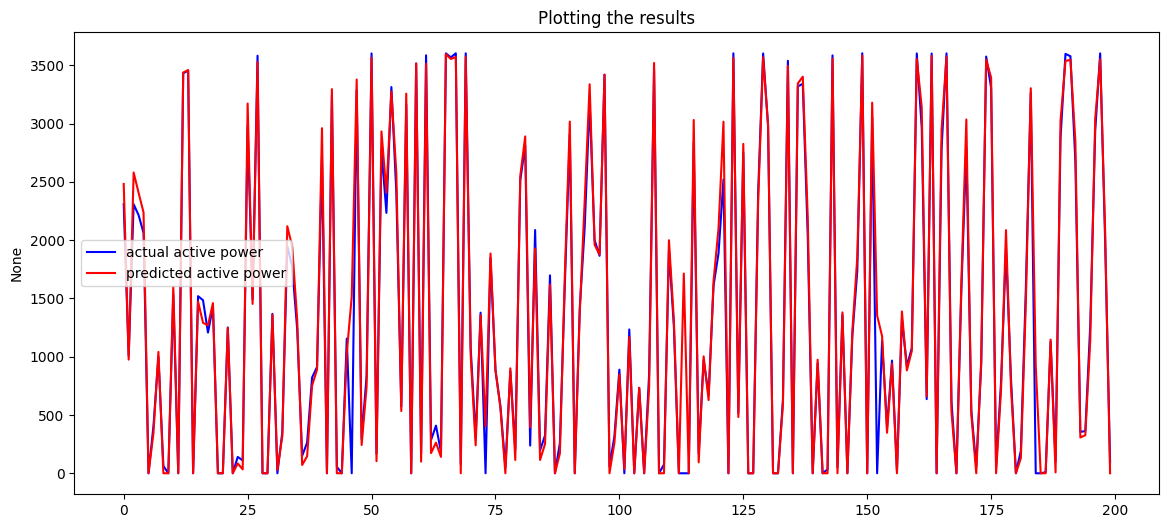

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

reconstructed_data = []
for x in X_train:
    r_data = model(x).detach().numpy()
    reconstructed_data.append(r_data[0])

plt.figure(figsize=(14, 6))
length = 200
sns.lineplot(x = range(length), y = y_train[200:400, 0], label = 'actual active power', color = "blue")
sns.lineplot(x = range(length), y = reconstructed_data[200:400], label = 'predicted active power', color = "r")
plt.title('Plotting the results')
plt.legend()
plt.show()

We can see that it might be overfitting. Let's try it on test set and plot it.

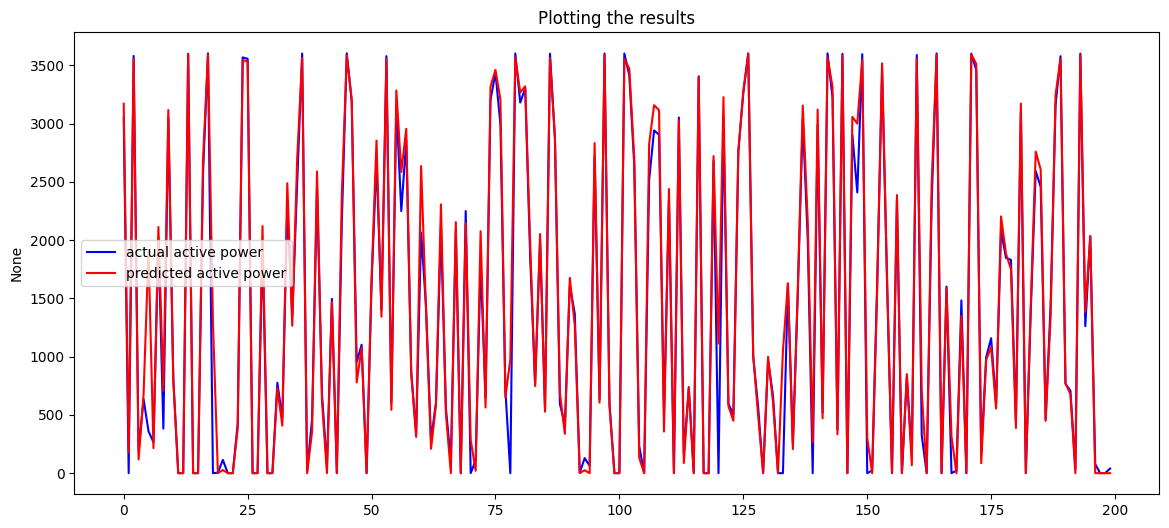

In [274]:
reconstructed_data = []
for x in X_test:
    r_data = model(x).detach().numpy()
    reconstructed_data.append(r_data[0])

plt.figure(figsize=(14, 6))
length = 200
sns.lineplot(x = range(length), y = y_test[0:200, 0], label = 'actual active power', color = "b")
sns.lineplot(x = range(length), y = reconstructed_data[0:200], label = 'predicted active power', color = "r")
plt.title('Plotting the results')
plt.legend()
plt.show()

The model is not very stable, as it is sensitive to hyperparameters, for example learning rate and the choice of hidden size. However, the total MSELoss for our choice of hyperparameters is good. Let's see if it can help detect anomalies.

In [275]:
reconstructed_data = []
for x in X:
    r_data = model(x).detach().numpy()
    reconstructed_data.append(r_data[0])

In [276]:
reconstructed_data = np.array(reconstructed_data)
reconstructed_data.shape

(50530,)

In [277]:
reconstructed_data = reconstructed_data.reshape(-1,1)
reconstructed_data.shape

(50530, 1)

In [281]:
active_power = y[:,0]
active_power = active_power.reshape(-1, 1)
active_power = active_power.detach().numpy()
active_power.shape

(50530, 1)

In [294]:
residuals = active_power - reconstructed_data
residuals = residuals.squeeze()
residuals.shape

(50530,)

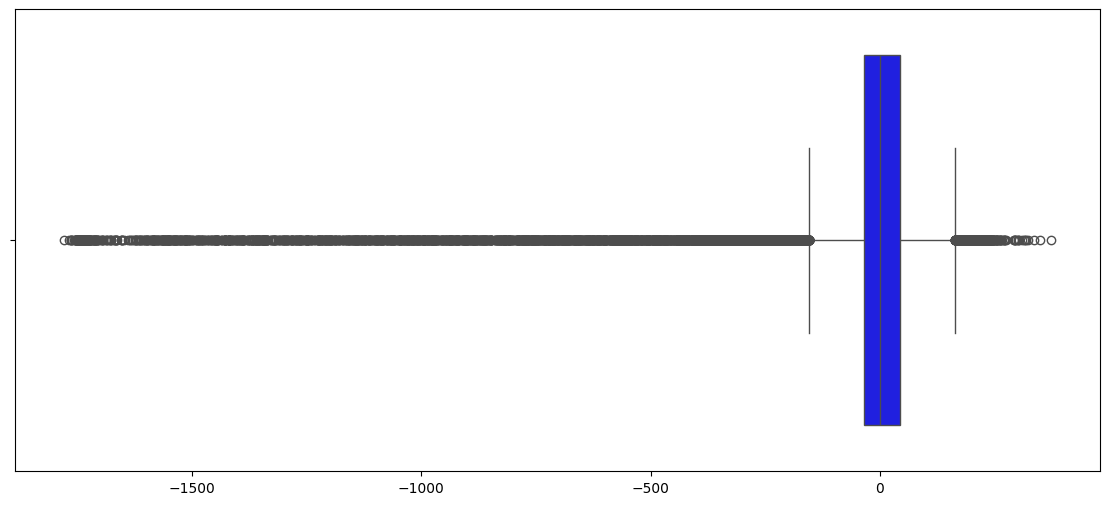

In [295]:
plt.figure(figsize=(14,6))
sns.boxplot(
    x = residuals,
    color = 'b'
)
plt.show()

The result is quite close to the linear model. When actual active power - predicted value < -200 or active power - predicted value > 200, there should be anomalies.